c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


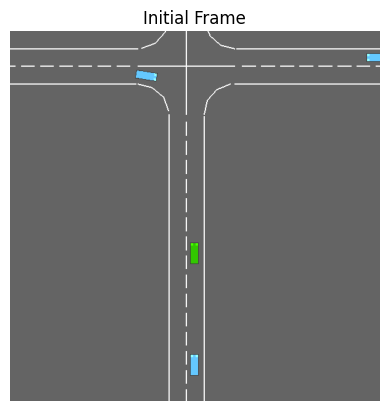

In [1]:
# Import libraries and make sure highway-env is installed properly
import highway_env
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
# pprint([env for env in gym.envs.registry.keys() if "intersection" in env])

# Create the environment with visual rendering
env = gym.make("intersection-v0", render_mode="rgb_array")
obs, info = env.reset()

# Render and show the first frame
frame = env.render()
plt.imshow(frame)
plt.axis('off')
plt.title("Initial Frame")
plt.show()

env.close()

In [2]:
from pprint import pprint

# print the environment information
print("Environment Information:")
pprint(env.unwrapped.config)

Environment Information:
{'action': {'lateral': False,
            'longitudinal': True,
            'target_speeds': [0, 4.5, 9],
            'type': 'DiscreteMetaAction'},
 'arrived_reward': 1,
 'centering_position': [0.5, 0.6],
 'collision_reward': -5,
 'controlled_vehicles': 1,
 'destination': 'o1',
 'duration': 13,
 'high_speed_reward': 1,
 'initial_vehicle_count': 10,
 'manual_control': False,
 'normalize_reward': False,
 'observation': {'absolute': True,
                 'features': ['presence',
                              'x',
                              'y',
                              'vx',
                              'vy',
                              'cos_h',
                              'sin_h'],
                 'features_range': {'vx': [-20, 20],
                                    'vy': [-20, 20],
                                    'x': [-100, 100],
                                    'y': [-100, 100]},
                 'flatten': False,
                 'obs

In [3]:
import torch
import tensorboard

print(tensorboard.__version__)
print(torch.cuda.is_available())   # Should be True
print(torch.cuda.get_device_name(0))  # Should show GPU name


2.17.1
True
NVIDIA GeForce RTX 3080


In [4]:
from stable_baselines3.common.monitor import Monitor

def make_env(render_mode=None):
    from gymnasium.wrappers import TimeLimit
    def _init():
        config = {
            "action": {
                "type": "ContinuousAction",
                "lateral": False,         # Disable lane change
                "longitudinal": True      # Enable acceleration/deceleration
            }
        }
        env = gym.make("intersection-v0", render_mode=render_mode, config=config)
        env = TimeLimit(env, max_episode_steps=200)
        env = Monitor(env)
        return env
    return _init

In [5]:
from stable_baselines3.common.vec_env import DummyVecEnv
import gymnasium as gym

env = DummyVecEnv([make_env(render_mode=None)])
# print the action space
print("Action Space:", env.action_space)

Action Space: Box(-1.0, 1.0, (1,), float32)


c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(


In [6]:
import os
import json
import optuna
import torch
import gymnasium as gym
from stable_baselines3 import SAC
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.callbacks import BaseCallback
from optuna.pruners import MedianPruner

# === Configuration ===
SAVE_DIR = "../trained_models/intersection/SAC/"
os.makedirs(SAVE_DIR, exist_ok=True)

COARSE_PARAMS_PATH = os.path.join(SAVE_DIR, "SAC_best_coarse_params.json")

# Track best rewards per phase
best_rewards = {"coarse": -float("inf"), "fine": -float("inf")}

# === Optuna Callback for pruning ===
class OptunaCallback(BaseCallback):
    def __init__(self, trial, eval_freq=2000, n_eval_episodes=3, verbose=0):
        super().__init__(verbose)
        self.trial = trial
        self.eval_freq = eval_freq
        self.n_eval_episodes = n_eval_episodes

    def _on_step(self):
        if self.n_calls % self.eval_freq == 0:
            reward, _ = evaluate_policy(self.model, self.training_env, n_eval_episodes=self.n_eval_episodes, deterministic=True)
            self.trial.report(reward, self.n_calls)
            if self.trial.should_prune():
                raise optuna.exceptions.TrialPruned()
        return True

# === Objective Function ===
def objective(trial, phase, coarse_params=None):
    global best_rewards

    # Coarse tuning: explore main params
    if phase == "coarse":
        buffer_size = trial.suggest_categorical("buffer_size", [5000, 10_000, 20_000, 30_000])
        learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
        gamma = trial.suggest_float("gamma", 0.85, 0.999)
        net_arch = trial.suggest_categorical("net_arch", [[64, 64], [128, 128], [256, 256]])
        
        config = {
            "learning_rate": learning_rate,
            "gamma": gamma,
            "net_arch": net_arch,
            "buffer_size": buffer_size,
        }

    # Fine tuning: fix coarse, tune others
    elif phase == "fine":
        assert coarse_params is not None, "Missing coarse parameters for fine tuning"
        
        learning_starts = trial.suggest_int("learning_starts", 200, 2000)
        batch_size = trial.suggest_categorical("batch_size", [64, 128, 256, 512])
        tau = trial.suggest_float("tau", 0.005, 0.02)
        ent_coef = trial.suggest_categorical("ent_coef", ["auto", "auto_0.1", 1e-3, 1e-2])
        
        config = {
            **coarse_params,
            "learning_starts": config.get("learning_starts", learning_starts),
            "batch_size": batch_size,
            "tau": tau,
            "ent_coef": ent_coef,
        }

    # Create env and model
    env = make_vec_env(make_env(), n_envs=1)
    model = SAC(
        "MlpPolicy",
        env,
        learning_rate=config["learning_rate"],
        gamma=config["gamma"],
        policy_kwargs={"net_arch": config["net_arch"]},
        batch_size=config.get("batch_size", 64),
        buffer_size=config.get("buffer_size", 20_000),
        learning_starts=config.get("learning_starts", 1_000),
        tau=config.get("tau", 0.005),
        train_freq=config.get("train_freq", 1),
        gradient_steps=config.get("gradient_steps", 1),
        ent_coef=config.get("ent_coef", "auto"),
        target_update_interval=config.get("target_update_interval", 1),
        verbose=0,
        tensorboard_log=f"../tensorboard_logs/intersection/SAC_phase_{phase}",
        device="cpu"
    )

    print(f"Starting training for trial {trial.number}...")
    print(f"Phase: {phase}, Config: {config}")
    model.learn(total_timesteps=40_000, callback=OptunaCallback(trial))

    mean_reward, _ = evaluate_policy(model, env, n_eval_episodes=5, deterministic=True)
    trial.set_user_attr("mean_reward", mean_reward)

    # Save best model immediately when improved
    if mean_reward > best_rewards[phase]:
        best_rewards[phase] = mean_reward
        model.save(os.path.join(SAVE_DIR, f"SAC_best_{phase}.zip"))
        print(f"Saved new best {phase} model (trial {trial.number})")
        if phase == "coarse":
            with open(COARSE_PARAMS_PATH, "w") as f:
                json.dump(config, f, indent=2)
            print(f"✅ Coarse tuning updated. Best trial {trial.number} saved.")

    return mean_reward

# === PHASE 1: Coarse Tuning ===
def run_coarse_phase():
    print("Starting COARSE tuning...")
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(seed=42),
        pruner=MedianPruner(n_startup_trials=3, n_warmup_steps=1)
    )
    study.optimize(lambda trial: objective(trial, phase="coarse"), n_trials=8)

# === PHASE 2: Fine Tuning ===
def run_fine_phase():
    if not os.path.exists(COARSE_PARAMS_PATH):
        raise FileNotFoundError("Missing coarse phase results. Run coarse phase first.")
    with open(COARSE_PARAMS_PATH, "r") as f:
        coarse_params = json.load(f)

    print("Starting FINE tuning with coarse-fixed params...")
    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(seed=123),
        pruner=MedianPruner(n_startup_trials=3, n_warmup_steps=1)
    )
    study.optimize(lambda trial: objective(trial, phase="fine", coarse_params=coarse_params), n_trials=8)
    print("✅ Fine tuning complete.")

# === MAIN ===
run_coarse = True
run_fine = True

if run_coarse:
    run_coarse_phase()

if run_fine:
    run_fine_phase()

[I 2025-07-31 09:27:18,170] A new study created in memory with name: no-name-e51c82b1-3def-45b7-a5a6-cf6c18ab8ba3
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64, 64] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highwa

Starting COARSE tuning...
Starting training for trial 0...
Phase: coarse, Config: {'learning_rate': 2.0513382630874486e-05, 'gamma': 0.8732431835300942, 'net_arch': [128, 128], 'buffer_size': 10000}


[I 2025-07-31 10:22:10,065] Trial 0 finished with value: 1.9398091999999998 and parameters: {'buffer_size': 10000, 'learning_rate': 2.0513382630874486e-05, 'gamma': 0.8732431835300942, 'net_arch': [128, 128]}. Best is trial 0 with value: 1.9398091999999998.


Saved new best coarse model (trial 0)
✅ Coarse tuning updated. Best trial 0 saved.
Starting training for trial 1...
Phase: coarse, Config: {'learning_rate': 2.6587543983272695e-05, 'gamma': 0.877091920113858, 'net_arch': [256, 256], 'buffer_size': 20000}


c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64, 64] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 

Saved new best coarse model (trial 1)
✅ Coarse tuning updated. Best trial 1 saved.
Starting training for trial 2...
Phase: coarse, Config: {'learning_rate': 3.8396292998041685e-05, 'gamma': 0.90458791465076, 'net_arch': [128, 128], 'buffer_size': 20000}


c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64, 64] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 

Starting training for trial 3...
Phase: coarse, Config: {'learning_rate': 2.1930485556643678e-05, 'gamma': 0.8596926873548066, 'net_arch': [128, 128], 'buffer_size': 30000}


[I 2025-07-31 12:14:06,892] Trial 3 pruned. 
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64, 64] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWa

Starting training for trial 4...
Phase: coarse, Config: {'learning_rate': 1.7541893487450798e-05, 'gamma': 0.9237813596065793, 'net_arch': [128, 128], 'buffer_size': 20000}


[I 2025-07-31 13:08:48,329] Trial 4 finished with value: 5.4 and parameters: {'buffer_size': 20000, 'learning_rate': 1.7541893487450798e-05, 'gamma': 0.9237813596065793, 'net_arch': [128, 128]}. Best is trial 4 with value: 5.4.


Saved new best coarse model (trial 4)
✅ Coarse tuning updated. Best trial 4 saved.
Starting training for trial 5...
Phase: coarse, Config: {'learning_rate': 2.3426581058204037e-05, 'gamma': 0.9944681095369192, 'net_arch': [128, 128], 'buffer_size': 5000}


c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64, 64] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWarning: WARN: The environment intersection-v0 

Starting training for trial 6...
Phase: coarse, Config: {'learning_rate': 1.2315571723666024e-05, 'gamma': 0.8984742192837264, 'net_arch': [256, 256], 'buffer_size': 10000}


[I 2025-07-31 14:06:00,016] Trial 6 pruned. 
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [64, 64] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [128, 128] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\distributions.py:518: UserWarning: Choices for a categorical distribution should be a tuple of None, bool, int, float and str for persistent storage but contains [256, 256] which is of type list.
  warnings.warn(message)
c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\gymnasium\envs\registration.py:513: DeprecationWa

Starting training for trial 7...
Phase: coarse, Config: {'learning_rate': 0.0004021554526690286, 'gamma': 0.8611080459082858, 'net_arch': [64, 64], 'buffer_size': 20000}


[I 2025-07-31 14:58:17,070] Trial 7 finished with value: 4.4 and parameters: {'buffer_size': 20000, 'learning_rate': 0.0004021554526690286, 'gamma': 0.8611080459082858, 'net_arch': [64, 64]}. Best is trial 4 with value: 5.4.
[I 2025-07-31 14:58:17,087] A new study created in memory with name: no-name-1079525c-c49e-4ab8-944f-11a28e22559f
[W 2025-07-31 14:58:17,088] Trial 0 failed with parameters: {'learning_starts': 1454, 'batch_size': 512, 'tau': 0.011346596901866915, 'ent_coef': 'auto'} because of the following error: UnboundLocalError("local variable 'config' referenced before assignment").
Traceback (most recent call last):
  File "c:\Users\sanja\anaconda3\envs\highway\lib\site-packages\optuna\study\_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
  File "C:\Users\sanja\AppData\Local\Temp\ipykernel_30232\2035702726.py", line 136, in <lambda>
    study.optimize(lambda trial: objective(trial, phase="fine", coarse_params=coarse_params), n_trials=8)
  File "C:\Us

Starting FINE tuning with coarse-fixed params...


UnboundLocalError: local variable 'config' referenced before assignment

In [ ]:
import os
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.monitor import Monitor
import gymnasium as gym

SAVE_DIR = "../trained_models/intersection/SAC/"
# === Load trained Optuna model ===
model_path = os.path.join(SAVE_DIR, "SAC_best_fine.zip")
model = SAC.load(model_path)

# === Environment for continued training ===
train_env = make_vec_env(make_env(), n_envs=1)

# === Rebind environment in case original wasn't saved in model ===
model.set_env(train_env)

# === Training configuration ===
total_timesteps = 40000
save_interval = 10000
timesteps_run = 0

cp_log_dir = f"../checkpoints/intersection/SAC_optuna"
os.makedirs(cp_log_dir, exist_ok=True)

while timesteps_run < total_timesteps:
    model.learn(
        total_timesteps=save_interval,
        reset_num_timesteps=False,
        tb_log_name="intersection_SAC_optuna",
        log_interval=1,
    )
    timesteps_run += save_interval
    model.save(f"{cp_log_dir}/{timesteps_run}")
    print(f"✅ Saved checkpoint at {timesteps_run} timesteps")

# === Save final model ===
final_model_path = os.path.join(SAVE_DIR, "SAC_trained_tuned.zip")
model.save(final_model_path)
print(f"✅ Final model saved at {final_model_path}")


In [ ]:
algo_name = 'SAC'

tuned_eval_dir = f"tuned/intersection/{algo_name}_tuned/"
video_eval_dir = os.path.join(tuned_eval_dir, "video_eval")
os.makedirs(video_eval_dir, exist_ok=True)

# Run 5 evaluation episodes and save each video
for episode in range(5):
    eval_env = DummyVecEnv([make_env(render_mode="rgb_array")])
    eval_env = VecVideoRecorder(
        eval_env,
        video_folder=video_eval_dir,
        record_video_trigger=lambda step: step == 0,
        video_length=200,
        name_prefix=f"tuned_ppo{episode+1}"  # ✅ Unique name per video
    )

    obs = eval_env.reset()
    for _ in range(200):
        action, _ = model.predict(obs, deterministic=True)
        obs, _, dones, _ = eval_env.step(action)
        if dones[0]:
            break

    eval_env.close()
    print(f"🎥 Saved video for episode {episode+1}")
